In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
from tqdm.auto import tqdm
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']="True"

In [2]:
path="C:\\Users\\EnanSaif\\Downloads\\data.csv"
test_path="C:\\Users\\EnanSaif\\Downloads\\test_data.csv"

In [3]:
class train_dataset(Dataset):
    def __init__(self):
        xy=pd.read_csv(path)
        self.x=torch.tensor(xy.iloc[:,:-1].values)
        self.y=torch.tensor(xy.iloc[:,-1].values)
        self.n_samples=xy.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples
class test_dataset(Dataset):
    def __init__(self):
        xy=pd.read_csv(test_path)
        self.x=torch.tensor(xy.iloc[:,:-1].values)
        self.y=torch.tensor(xy.iloc[:,-1].values)
        self.n_samples=xy.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples

In [4]:
def block(input_dim,out_dim):
    return nn.Sequential(
    nn.Linear(input_dim,out_dim),
    nn.BatchNorm1d(out_dim),
    nn.ReLU()
    )

In [5]:
class Model(nn.Module):
    def __init__(self,input_dim,num_classes,hidden_dim):
        super(Model,self).__init__()
        self.net=nn.Sequential(
        block(input_dim,hidden_dim*2),
        block(hidden_dim*2,hidden_dim*4),
        block(hidden_dim*4,hidden_dim*8),
        block(hidden_dim*8,num_classes)
        )
    def forward(self,x):
        return self.net(x)

In [6]:
n_epoch=200
batch_size=8
input_size=14
num_classes=5
hidden_units=64
criterion=nn.CrossEntropyLoss()
model=Model(input_size,num_classes,hidden_units)
optimizer=optim.Adam(model.parameters(),lr=.001)

def acc(data,model):
    num_correct=0
    num_sample=0
    model.eval()
    with torch.no_grad():
        for input,label in data:
            _,pred=model(input.float()).max(1)
            label=label-1
            num_correct+=(pred==label).sum()
            num_sample+=pred.size(0)
        acc=num_correct/num_sample
    return acc.item()

In [7]:
dataset=train_dataset()
dataloader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
test_dataset=test_dataset()
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

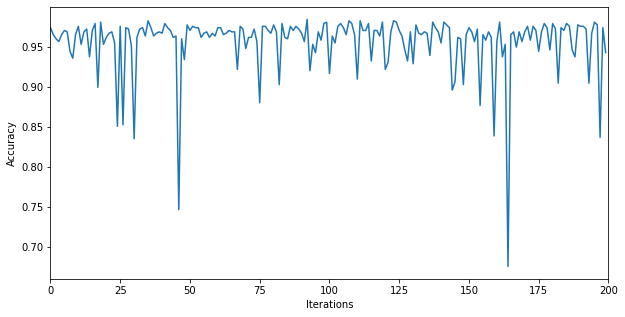

In [14]:
a=[]
for epoch in range(n_epoch):
    for input,labels in tqdm(dataloader):
        pred=model(input.float())
        y = torch.zeros(batch_size,num_classes)
        labels=labels-1
        y[range(y.shape[0]),labels]=1
        loss=criterion(pred,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy=acc(dataloader,model)
    a.append(accuracy)
plt.figure(figsize=(10,5))
plt.plot(a)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.xlim([0,200])
plt.show()

In [15]:
acc(dataloader,model)

0.9427083134651184

In [16]:
acc(test_dataloader,model)

0.703125

In [11]:
def return_preds(data,model):
    model.eval()
    preds=torch.tensor([])
    labels=torch.tensor([])
    with torch.no_grad():
        for input,label in data:
            pred=model(input.float())
            preds=torch.cat((preds,pred),dim=0)
            predictions=preds.argmax(dim=1)
            label=label-1
            labels=torch.cat((labels,label),dim=0)
    return predictions,labels

In [12]:
pred_tensor,labels=return_preds(test_dataloader,model)
pred_tensor=pred_tensor.int()
labels=labels.int()
stacked=torch.stack((labels,pred_tensor),dim=1)
i_am_confusion=torch.zeros(5,5,dtype=torch.int32)
for i in stacked:
    true,pred=i.tolist()
    i_am_confusion[true,pred]=i_am_confusion[true,pred]+1

In [13]:
print(i_am_confusion)

tensor([[25,  0,  0,  0,  1],
        [ 0, 11,  0,  0,  0],
        [ 4,  7,  0,  1,  0],
        [ 0,  0,  0,  5,  0],
        [ 0,  0,  0,  0, 10]], dtype=torch.int32)
